In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import random as rand
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, RationalQuadratic as RQ, WhiteKernel as W, ExpSineSquared as ExpSS, DotProduct as DP, Matern as Mt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_monthly=pd.read_csv('AAPL_parent_monthly.csv')
df_monthly

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-01,19.779285,19.821428,15.535714,16.267500,13.968525,13123423600
1,2013-02-01,16.396786,17.319286,15.630714,15.764286,13.536427,9344034000
2,2013-03-01,15.642857,16.783930,14.964286,15.809286,13.654184,9176876800
3,2013-04-01,15.782143,15.901786,13.753571,15.813571,13.657885,10963489600
4,2013-05-01,15.873571,16.633928,14.960714,16.061787,13.872264,9447530400
...,...,...,...,...,...,...,...
119,2022-12-01,148.210007,150.919998,125.870003,129.929993,129.731918,1675731200
120,2023-01-01,130.279999,147.229996,124.169998,144.289993,144.070023,1443652500
121,2023-02-01,143.970001,157.380005,141.320007,147.410004,147.185272,1307198900
122,2023-03-01,146.830002,159.399994,143.899994,159.279999,159.279999,1049543200


In [3]:
df_monthly = df_monthly.assign(Avg_price=lambda x: ((x['Open'] + x['High'] + x['Low'] + x['Close'])/4))
start=1
df_monthly.insert(0, 'Month', range(start, start + df_monthly.shape[0]))
df_monthly

,Month,Date,Open,High,Low,Close,Adj Close,Volume,Avg_price
0,1,2013-01-01,19.779285,19.821428,15.535714,16.267500,13.968525,13123423600,17.850982
1,2,2013-02-01,16.396786,17.319286,15.630714,15.764286,13.536427,9344034000,16.277768
2,3,2013-03-01,15.642857,16.783930,14.964286,15.809286,13.654184,9176876800,15.800090
3,4,2013-04-01,15.782143,15.901786,13.753571,15.813571,13.657885,10963489600,15.312768
4,5,2013-05-01,15.873571,16.633928,14.960714,16.061787,13.872264,9447530400,15.882500
...,...,...,...,...,...,...,...,...,...
119,120,2022-12-01,148.210007,150.919998,125.870003,129.929993,129.731918,1675731200,138.732500
120,121,2023-01-01,130.279999,147.229996,124.169998,144.289993,144.070023,1443652500,136.492497
121,122,2023-02-01,143.970001,157.380005,141.320007,147.410004,147.185272,1307198900,147.520004
122,123,2023-03-01,146.830002,159.399994,143.899994,159.279999,159.279999,1049543200,152.352497


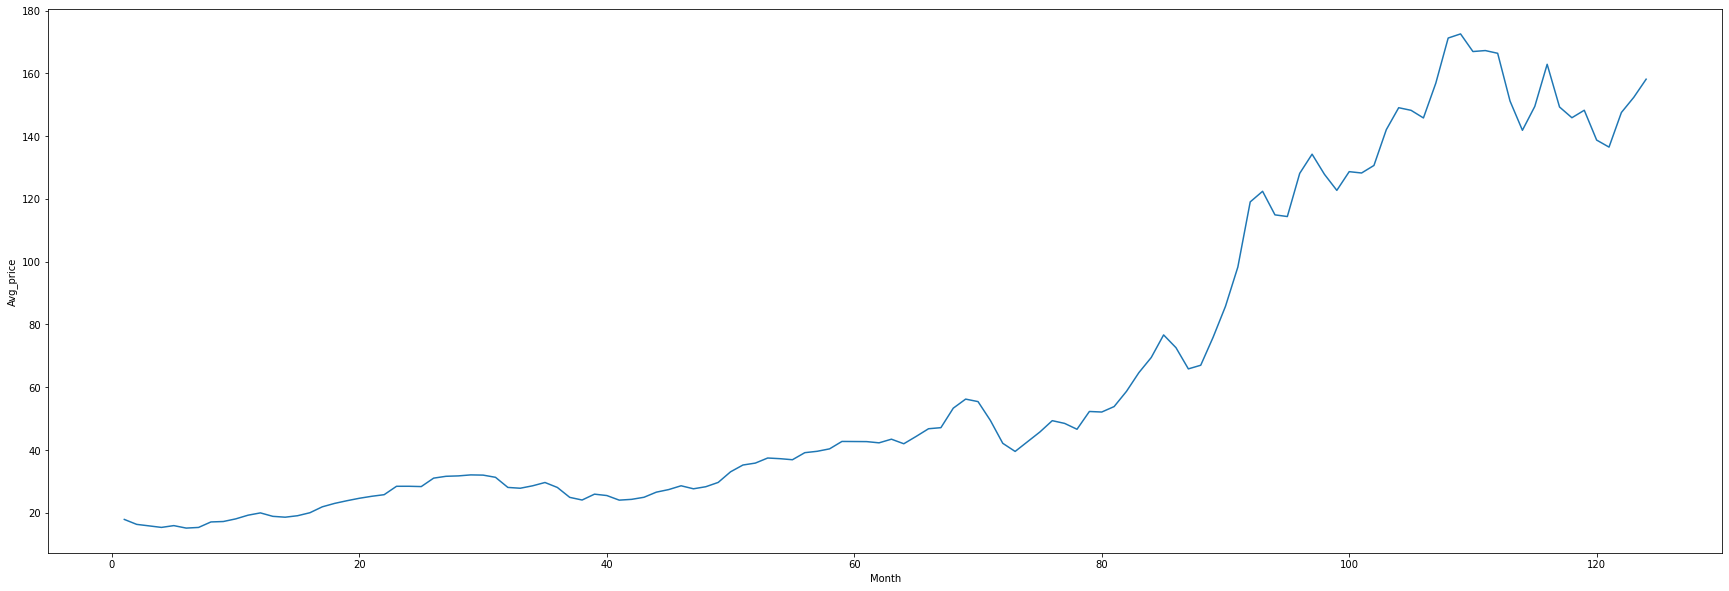

In [4]:
plt.figure(figsize=(30,10))
sns.lineplot(x="Month", y="Avg_price", data=df_monthly)
plt.show()

In [5]:
df_monthly_array=np.asarray(df_monthly)
df_monthly_array

array([[1, '2013-01-01', 19.779285, ..., 13.968525, 13123423600,
        17.85098175],
       [2, '2013-02-01', 16.396786, ..., 13.536427, 9344034000,
        16.277768],
       [3, '2013-03-01', 15.642857, ..., 13.654184, 9176876800,
        15.800089750000001],
       ...,
       [122, '2023-02-01', 143.970001, ..., 147.185272, 1307198900,
        147.52000425],
       [123, '2023-03-01', 146.830002, ..., 159.279999, 1049543200,
        152.35249725],
       [124, '2023-03-21', 157.320007, ..., 159.279999, 73938285,
        158.13499825]], dtype=object)

In [6]:
kernel_1=C()*Mt(nu=1.5)+ExpSS(length_scale=10, periodicity=6)
kernel_2=C()*Mt(nu=2.5)
kernel_3=C()*RBF(length_scale=100)
C_1=C()
C_2=C()
kernel_4=C()*ExpSS(length_scale=10, periodicity=10)+C()*RBF(length_scale=10)
kernel_5=C_1*ExpSS(length_scale=10, periodicity=10)+C_2*RBF(length_scale=10)
kernel_6=C()*ExpSS(length_scale=10, periodicity=6)+RBF(length_scale=100)
kernel_7=C()*Mt(nu=1.5)+RBF(length_scale=10)
kernel_8=Mt(nu=1.5)+C()*RBF(length_scale=10)

In [7]:
abs_error_compiled=[]
error_compiled=[]
for i in range(60,124):
    
    X_train=np.atleast_2d(df_monthly_array[i-24:i,0]).T
    X_whole=np.atleast_2d(df_monthly_array[i-24:i+1,0]).T
    
    Y_train=df_monthly_array[i-24:i,8].T
    Y_whole=df_monthly_array[i-24:i+1,8].T
    
    X_test=np.atleast_2d(np.linspace(i-24,i+1,250)).T
    X_test_modified=[]
    for j in X_test:
        X_test_modified.append([round(float(j), 1)])
    X_test_modified=np.array(X_test_modified)
    
    gp=GaussianProcessRegressor(kernel=kernel_8, n_restarts_optimizer=100, normalize_y=True, random_state=2 )
    gp.fit(X_train,Y_train)
    Y_pred,sigma=gp.predict(X_test_modified, return_std=True)
    
    X_test_new=np.atleast_2d(df_monthly_array[i:i+1,0]).T
    Y_test_new=df_monthly_array[i:i+1,8].T
    Y_pred_modified=[]
    for k in X_test_new:
        temp=list(X_test_modified).index(k)
        Y_pred_modified.append(Y_pred[temp])
        
    abs_error =np.abs(Y_test_new[0]-Y_pred_modified[0])
    abs_error_compiled.append(abs_error)
    
    error=Y_test_new[0]-Y_pred_modified[0]
    error_compiled.append(error)
    print(i+1,abs_error,error)  
print('Mean Absolute Deviation = ',np.array(abs_error_compiled).mean())

61 0.36963897622351993 0.36963897622351993
62 0.6509064131265276 -0.6509064131265276
63 1.6146314583414139 1.6146314583414139
64 1.7222188607058868 -1.7222188607058868
65 2.9354607094966454 2.9354607094966454
66 2.4701207983974456 2.4701207983974456
67 0.7112621471790561 0.7112621471790561
68 6.285323938143115 6.285323938143115
69 2.658947184210419 2.658947184210419
70 1.944616017782515 -1.944616017782515
71 5.711219320189855 -5.711219320189855
72 3.5362709444472102 -3.5362709444472102
73 1.676060746506991 1.676060746506991
74 3.369874008959698 3.369874008959698
75 0.6967153162922486 0.6967153162922486
76 2.5341849627934323 2.5341849627934323
77 1.9839447360739797 -1.9839447360739797
78 0.0817330192823249 -0.0817330192823249
79 6.9007325866986235 6.9007325866986235
80 2.4065720563786783 -2.4065720563786783
81 3.8386946166158893 3.8386946166158893
82 5.806128941898436 5.806128941898436
83 6.006651639705957 6.006651639705957
84 4.5037836149078885 4.5037836149078885
85 7.444217027112472 7

In [8]:
MAD=[]
for l in range(1,51,5):
    abs_error_compiled=[]
    error_compiled=[]
    for i in range(60,124):
    
        X_train=np.atleast_2d(df_monthly_array[i-24:i,0]).T
        X_whole=np.atleast_2d(df_monthly_array[i-24:i+1,0]).T
    
        Y_train=df_monthly_array[i-24:i,8].T
        Y_whole=df_monthly_array[i-24:i+1,8].T
    
        X_test=np.atleast_2d(np.linspace(i-24,i+1,250)).T
        X_test_modified=[]
        for j in X_test:
            X_test_modified.append([round(float(j), 1)])
        X_test_modified=np.array(X_test_modified)
    
        kernel_8=Mt(nu=1.5)+C()*RBF(length_scale=l)        
        gp=GaussianProcessRegressor(kernel=kernel_8, n_restarts_optimizer=100, normalize_y=True, random_state=2 )
        gp.fit(X_train,Y_train)
        Y_pred,sigma=gp.predict(X_test_modified, return_std=True)
    
        X_test_new=np.atleast_2d(df_monthly_array[i:i+1,0]).T
        Y_test_new=df_monthly_array[i:i+1,8].T
        Y_pred_modified=[]
        for k in X_test_new:
            temp=list(X_test_modified).index(k)
            Y_pred_modified.append(Y_pred[temp])
        
        abs_error =np.abs(Y_test_new[0]-Y_pred_modified[0])
        abs_error_compiled.append(abs_error)
    
        error=Y_test_new[0]-Y_pred_modified[0]
        error_compiled.append(error)
    print(l,np.array(abs_error_compiled).mean())
    MAD.append(np.array(abs_error_compiled).mean())

1 5.115561366897296
6 5.085329054963577
11 5.090966149951777
16 5.085327718599375
21 5.085460716659361
26 5.085460397271207
31 5.1155616160883115
36 5.085460368967185
41 5.085460504611925
46 5.085460482535487


In [9]:
MAD=[]
for l in range(1,51,5):
    abs_error_compiled=[]
    error_compiled=[]
    for i in range(60,124):
    
        X_train=np.atleast_2d(df_monthly_array[i-24:i,0]).T
        X_whole=np.atleast_2d(df_monthly_array[i-24:i+1,0]).T
    
        Y_train=df_monthly_array[i-24:i,8].T
        Y_whole=df_monthly_array[i-24:i+1,8].T
    
        X_test=np.atleast_2d(np.linspace(i-24,i+1,250)).T
        X_test_modified=[]
        for j in X_test:
            X_test_modified.append([round(float(j), 1)])
        X_test_modified=np.array(X_test_modified)
    
        kernel_8=Mt(nu=2.5)+C()*RBF(length_scale=l)        
        gp=GaussianProcessRegressor(kernel=kernel_8, n_restarts_optimizer=100, normalize_y=True, random_state=2 )
        gp.fit(X_train,Y_train)
        Y_pred,sigma=gp.predict(X_test_modified, return_std=True)
    
        X_test_new=np.atleast_2d(df_monthly_array[i:i+1,0]).T
        Y_test_new=df_monthly_array[i:i+1,8].T
        Y_pred_modified=[]
        for k in X_test_new:
            temp=list(X_test_modified).index(k)
            Y_pred_modified.append(Y_pred[temp])
        
        abs_error =np.abs(Y_test_new[0]-Y_pred_modified[0])
        abs_error_compiled.append(abs_error)
    
        error=Y_test_new[0]-Y_pred_modified[0]
        error_compiled.append(error)
    print(l,np.array(abs_error_compiled).mean())
    MAD.append(np.array(abs_error_compiled).mean())

1 5.027804306152565
6 5.00542192728669
11 5.005421733308479
16 5.005421836438522
21 5.005421746585185
26 5.005421720336974
31 5.005421863119221
36 5.0054217999660615
41 5.0054217663944165
46 5.005421636732587


In [10]:
MAD=[]
for l in range(1,51,5):
    abs_error_compiled=[]
    error_compiled=[]
    for i in range(60,124):
    
        X_train=np.atleast_2d(df_monthly_array[i-12:i,0]).T
        X_whole=np.atleast_2d(df_monthly_array[i-12:i+1,0]).T
    
        Y_train=df_monthly_array[i-12:i,8].T
        Y_whole=df_monthly_array[i-12:i+1,8].T
    
        X_test=np.atleast_2d(np.linspace(i-12,i+1,250)).T
        X_test_modified=[]
        for j in X_test:
            X_test_modified.append([round(float(j), 1)])
        X_test_modified=np.array(X_test_modified)
    
        kernel_8=Mt(nu=1.5)+C()*RBF(length_scale=l)        
        gp=GaussianProcessRegressor(kernel=kernel_8, n_restarts_optimizer=100, normalize_y=True, random_state=2 )
        gp.fit(X_train,Y_train)
        Y_pred,sigma=gp.predict(X_test_modified, return_std=True)
    
        X_test_new=np.atleast_2d(df_monthly_array[i:i+1,0]).T
        Y_test_new=df_monthly_array[i:i+1,8].T
        Y_pred_modified=[]
        for k in X_test_new:
            temp=list(X_test_modified).index(k)
            Y_pred_modified.append(Y_pred[temp])
        
        abs_error =np.abs(Y_test_new[0]-Y_pred_modified[0])
        abs_error_compiled.append(abs_error)
    
        error=Y_test_new[0]-Y_pred_modified[0]
        error_compiled.append(error)
    print(l,np.array(abs_error_compiled).mean())
    MAD.append(np.array(abs_error_compiled).mean())

1 5.207442239952574
6 5.218547132264872
11 5.218547105676801
16 5.207442730587914
21 5.218546998101718
26 5.207442883162873
31 5.218547029026205
36 5.218547120702743
41 5.218547270002947
46 5.2185468321475685


In [11]:
MAD=[]
for l in range(1,51,5):
    abs_error_compiled=[]
    error_compiled=[]
    for i in range(60,124):
    
        X_train=np.atleast_2d(df_monthly_array[i-12:i,0]).T
        X_whole=np.atleast_2d(df_monthly_array[i-12:i+1,0]).T
    
        Y_train=df_monthly_array[i-12:i,8].T
        Y_whole=df_monthly_array[i-12:i+1,8].T
    
        X_test=np.atleast_2d(np.linspace(i-12,i+1,250)).T
        X_test_modified=[]
        for j in X_test:
            X_test_modified.append([round(float(j), 1)])
        X_test_modified=np.array(X_test_modified)
    
        kernel_8=Mt(nu=2.5)+C()*RBF(length_scale=l)        
        gp=GaussianProcessRegressor(kernel=kernel_8, n_restarts_optimizer=100, normalize_y=True, random_state=2 )
        gp.fit(X_train,Y_train)
        Y_pred,sigma=gp.predict(X_test_modified, return_std=True)
    
        X_test_new=np.atleast_2d(df_monthly_array[i:i+1,0]).T
        Y_test_new=df_monthly_array[i:i+1,8].T
        Y_pred_modified=[]
        for k in X_test_new:
            temp=list(X_test_modified).index(k)
            Y_pred_modified.append(Y_pred[temp])
        
        abs_error =np.abs(Y_test_new[0]-Y_pred_modified[0])
        abs_error_compiled.append(abs_error)
    
        error=Y_test_new[0]-Y_pred_modified[0]
        error_compiled.append(error)
    print(l,np.array(abs_error_compiled).mean())
    MAD.append(np.array(abs_error_compiled).mean())

1 5.273016983387742
6 5.273016727100233
11 5.273015209852364
16 5.273015474239571
21 5.273015115263178
26 5.273015056426921
31 5.273015097821739
36 5.273014812695837
41 5.263165453684313
46 5.263165418893655


In [12]:
MAD=[]
for l in range(1,51,5):
    abs_error_compiled=[]
    error_compiled=[]
    for i in range(60,124):
    
        X_train=np.atleast_2d(df_monthly_array[i-36:i,0]).T
        X_whole=np.atleast_2d(df_monthly_array[i-36:i+1,0]).T
    
        Y_train=df_monthly_array[i-36:i,8].T
        Y_whole=df_monthly_array[i-36:i+1,8].T
    
        X_test=np.atleast_2d(np.linspace(i-36,i+1,250)).T
        X_test_modified=[]
        for j in X_test:
            X_test_modified.append([round(float(j), 1)])
        X_test_modified=np.array(X_test_modified)
    
        kernel_8=Mt(nu=1.5)+C()*RBF(length_scale=l)        
        gp=GaussianProcessRegressor(kernel=kernel_8, n_restarts_optimizer=100, normalize_y=True, random_state=2 )
        gp.fit(X_train,Y_train)
        Y_pred,sigma=gp.predict(X_test_modified, return_std=True)
    
        X_test_new=np.atleast_2d(df_monthly_array[i:i+1,0]).T
        Y_test_new=df_monthly_array[i:i+1,8].T
        Y_pred_modified=[]
        for k in X_test_new:
            temp=list(X_test_modified).index(k)
            Y_pred_modified.append(Y_pred[temp])
        
        abs_error =np.abs(Y_test_new[0]-Y_pred_modified[0])
        abs_error_compiled.append(abs_error)
    
        error=Y_test_new[0]-Y_pred_modified[0]
        error_compiled.append(error)
    print(l,np.array(abs_error_compiled).mean())
    MAD.append(np.array(abs_error_compiled).mean())

1 5.149438375021196
6 5.149438378188852
11 5.149438379280028
16 5.149438378188852
21 5.149438372879056
26 5.149438379302156
31 5.149438381464064
36 5.149438387265912
41 5.149438364887592
46 5.149438369198057


In [13]:
MAD=[]
for l in range(1,51,5):
    abs_error_compiled=[]
    error_compiled=[]
    for i in range(60,124):
    
        X_train=np.atleast_2d(df_monthly_array[i-36:i,0]).T
        X_whole=np.atleast_2d(df_monthly_array[i-36:i+1,0]).T
    
        Y_train=df_monthly_array[i-36:i,8].T
        Y_whole=df_monthly_array[i-36:i+1,8].T
    
        X_test=np.atleast_2d(np.linspace(i-36,i+1,250)).T
        X_test_modified=[]
        for j in X_test:
            X_test_modified.append([round(float(j), 1)])
        X_test_modified=np.array(X_test_modified)
    
        kernel_8=Mt(nu=2.5)+C()*RBF(length_scale=l)        
        gp=GaussianProcessRegressor(kernel=kernel_8, n_restarts_optimizer=100, normalize_y=True, random_state=2 )
        gp.fit(X_train,Y_train)
        Y_pred,sigma=gp.predict(X_test_modified, return_std=True)
    
        X_test_new=np.atleast_2d(df_monthly_array[i:i+1,0]).T
        Y_test_new=df_monthly_array[i:i+1,8].T
        Y_pred_modified=[]
        for k in X_test_new:
            temp=list(X_test_modified).index(k)
            Y_pred_modified.append(Y_pred[temp])
        
        abs_error =np.abs(Y_test_new[0]-Y_pred_modified[0])
        abs_error_compiled.append(abs_error)
    
        error=Y_test_new[0]-Y_pred_modified[0]
        error_compiled.append(error)
    print(l,np.array(abs_error_compiled).mean())
    MAD.append(np.array(abs_error_compiled).mean())

1 5.226820797337011
6 5.226820796507863
11 5.226820797373574
16 5.226820797337011
21 5.226820797337011
26 5.226820787837026
31 5.226820798286637
36 5.226820797337011
41 5.226820797337011
46 5.226820797337011


In [14]:
MAD=[]
for l in range(1,51,5):
    abs_error_compiled=[]
    error_compiled=[]
    for i in range(60,124):
    
        X_train=np.atleast_2d(df_monthly_array[i-24:i,0]).T
        X_whole=np.atleast_2d(df_monthly_array[i-24:i+1,0]).T
    
        Y_train=df_monthly_array[i-24:i,8].T
        Y_whole=df_monthly_array[i-24:i+1,8].T
    
        X_test=np.atleast_2d(np.linspace(i-24,i+1,250)).T
        X_test_modified=[]
        for j in X_test:
            X_test_modified.append([round(float(j), 1)])
        X_test_modified=np.array(X_test_modified)
    
        kernel_8=RBF(length_scale=l)        
        gp=GaussianProcessRegressor(kernel=kernel_8, n_restarts_optimizer=100, normalize_y=True, random_state=2 )
        gp.fit(X_train,Y_train)
        Y_pred,sigma=gp.predict(X_test_modified, return_std=True)
    
        X_test_new=np.atleast_2d(df_monthly_array[i:i+1,0]).T
        Y_test_new=df_monthly_array[i:i+1,8].T
        Y_pred_modified=[]
        for k in X_test_new:
            temp=list(X_test_modified).index(k)
            Y_pred_modified.append(Y_pred[temp])
        
        abs_error =np.abs(Y_test_new[0]-Y_pred_modified[0])
        abs_error_compiled.append(abs_error)
    
        error=Y_test_new[0]-Y_pred_modified[0]
        error_compiled.append(error)
    print(l,np.array(abs_error_compiled).mean())
    MAD.append(np.array(abs_error_compiled).mean())

1 7.331810555654693
6 7.3318105550420425
11 7.3318105550420425
16 7.3318105550420425
21 7.3318105550420425
26 7.3318105550420425
31 7.3318105550420425
36 7.3318105550420425
41 7.3318105550420425
46 7.3318105550420425


In [15]:
abs_error_compiled=[]
error_compiled=[]
for i in range(60,124):
    
    X_train=np.atleast_2d(df_monthly_array[i-24:i,0]).T
    X_whole=np.atleast_2d(df_monthly_array[i-24:i+1,0]).T
    
    Y_train=df_monthly_array[i-24:i,8].T
    Y_whole=df_monthly_array[i-24:i+1,8].T
    
    X_test=np.atleast_2d(np.linspace(i-24,i+1,250)).T
    X_test_modified=[]
    for j in X_test:
        X_test_modified.append([round(float(j), 1)])
    X_test_modified=np.array(X_test_modified)
    
    gp=GaussianProcessRegressor(kernel=Mt(nu=1.5), n_restarts_optimizer=100, normalize_y=True, random_state=2 )
    gp.fit(X_train,Y_train)
    Y_pred,sigma=gp.predict(X_test_modified, return_std=True)
    
    X_test_new=np.atleast_2d(df_monthly_array[i:i+1,0]).T
    Y_test_new=df_monthly_array[i:i+1,8].T
    Y_pred_modified=[]
    for k in X_test_new:
        temp=list(X_test_modified).index(k)
        Y_pred_modified.append(Y_pred[temp])
        
    abs_error =np.abs(Y_test_new[0]-Y_pred_modified[0])
    abs_error_compiled.append(abs_error)
    
    error=Y_test_new[0]-Y_pred_modified[0]
    error_compiled.append(error)
    print(i+1,abs_error,error)  
print('Mean Absolute Deviation = ',np.array(abs_error_compiled).mean())

61 1.1274068116278144 1.1274068116278144
62 0.09942898833985225 0.09942898833985225
63 1.9904440094340003 1.9904440094340003
64 1.9549260916856497 -1.9549260916856497
65 4.166540558373498 4.166540558373498
66 1.0386574718509678 1.0386574718509678
67 0.13466377746323133 -0.13466377746323133
68 7.017991940762435 7.017991940762435
69 0.31403083575420254 0.31403083575420254
70 0.1814306358958504 -0.1814306358958504
71 3.986658935594484 -3.986658935594484
72 2.8084630601661758 -2.8084630601661758
73 0.9048527594229867 0.9048527594229867
74 3.308860493888673 3.308860493888673
75 1.1905593903736644 1.1905593903736644
76 2.778997111838258 2.778997111838258
77 1.5978161261856272 -1.5978161261856272
78 0.3741130403449304 -0.3741130403449304
79 6.663538795442513 6.663538795442513
80 1.2130539657579504 -1.2130539657579504
81 3.7991544694213104 3.7991544694213104
82 5.712405497555196 5.712405497555196
83 6.674280599835633 6.674280599835633
84 5.610408177148152 5.610408177148152
85 8.259830263886428

In [16]:
abs_error_compiled=[]
error_compiled=[]
for i in range(60,124):
    
    X_train=np.atleast_2d(df_monthly_array[i-24:i,0]).T
    X_whole=np.atleast_2d(df_monthly_array[i-24:i+1,0]).T
    
    Y_train=df_monthly_array[i-24:i,8].T
    Y_whole=df_monthly_array[i-24:i+1,8].T
    
    X_test=np.atleast_2d(np.linspace(i-24,i+1,250)).T
    X_test_modified=[]
    for j in X_test:
        X_test_modified.append([round(float(j), 1)])
    X_test_modified=np.array(X_test_modified)
    
    gp=GaussianProcessRegressor(kernel=Mt(nu=2.5), n_restarts_optimizer=100, normalize_y=True, random_state=2 )
    gp.fit(X_train,Y_train)
    Y_pred,sigma=gp.predict(X_test_modified, return_std=True)
    
    X_test_new=np.atleast_2d(df_monthly_array[i:i+1,0]).T
    Y_test_new=df_monthly_array[i:i+1,8].T
    Y_pred_modified=[]
    for k in X_test_new:
        temp=list(X_test_modified).index(k)
        Y_pred_modified.append(Y_pred[temp])
        
    abs_error =np.abs(Y_test_new[0]-Y_pred_modified[0])
    abs_error_compiled.append(abs_error)
    
    error=Y_test_new[0]-Y_pred_modified[0]
    error_compiled.append(error)
    print(i+1,abs_error,error)  
print('Mean Absolute Deviation = ',np.array(abs_error_compiled).mean())

61 2.1001386501114823 2.1001386501114823
62 0.06734718696099407 0.06734718696099407
63 2.5437449822217246 2.5437449822217246
64 2.127582055047867 -2.127582055047867
65 5.242870237855989 5.242870237855989
66 0.33152011543754156 0.33152011543754156
67 0.8470606310704127 0.8470606310704127
68 7.555813401223638 7.555813401223638
69 0.21974328156755263 -0.21974328156755263
70 1.6264456321313787 1.6264456321313787
71 3.392735807519614 -3.392735807519614
72 1.6581321396300481 -1.6581321396300481
73 0.8801709369659321 0.8801709369659321
74 2.6692235872240957 2.6692235872240957
75 0.6129508495775511 0.6129508495775511
76 2.9777824615798067 2.9777824615798067
77 1.7500435572658333 -1.7500435572658333
78 0.36637984407848023 0.36637984407848023
79 6.586679398674164 6.586679398674164
80 1.9398818110965124 -1.9398818110965124
81 4.762053383758982 4.762053383758982
82 5.445823071368352 5.445823071368352
83 6.843824125795543 6.843824125795543
84 5.875251941290145 5.875251941290145
85 8.943827177545444

In [17]:
abs_error_compiled=[]
error_compiled=[]
for i in range(60,124):
    
    X_train=np.atleast_2d(df_monthly_array[i-24:i,0]).T
    X_whole=np.atleast_2d(df_monthly_array[i-24:i+1,0]).T
    
    Y_train=df_monthly_array[i-24:i,8].T
    Y_whole=df_monthly_array[i-24:i+1,8].T
    
    X_test=np.atleast_2d(np.linspace(i-24,i+1,250)).T
    X_test_modified=[]
    for j in X_test:
        X_test_modified.append([round(float(j), 1)])
    X_test_modified=np.array(X_test_modified)
    
    gp=GaussianProcessRegressor(kernel=C()*Mt(nu=1.5), n_restarts_optimizer=100, normalize_y=True, random_state=2 )
    gp.fit(X_train,Y_train)
    Y_pred,sigma=gp.predict(X_test_modified, return_std=True)
    
    X_test_new=np.atleast_2d(df_monthly_array[i:i+1,0]).T
    Y_test_new=df_monthly_array[i:i+1,8].T
    Y_pred_modified=[]
    for k in X_test_new:
        temp=list(X_test_modified).index(k)
        Y_pred_modified.append(Y_pred[temp])
        
    abs_error =np.abs(Y_test_new[0]-Y_pred_modified[0])
    abs_error_compiled.append(abs_error)
    
    error=Y_test_new[0]-Y_pred_modified[0]
    error_compiled.append(error)
    print(i+1,abs_error,error)  
print('Mean Absolute Deviation = ',np.array(abs_error_compiled).mean())

61 1.1746144934505196 1.1746144934505196
62 0.07737624447251079 0.07737624447251079
63 2.0363037328615903 2.0363037328615903
64 1.9163433101250718 -1.9163433101250718
65 4.170540644471487 4.170540644471487
66 0.9609855552864985 0.9609855552864985
67 0.2790039916242293 -0.2790039916242293
68 7.012778767396952 7.012778767396952
69 0.8868368437605412 -0.8868368437605412
70 0.41141938057241845 -0.41141938057241845
71 4.058870718247412 -4.058870718247412
72 2.7865706924373868 -2.7865706924373868
73 1.2224817479722674 1.2224817479722674
74 3.3617174519429867 3.3617174519429867
75 1.167464461544789 1.167464461544789
76 2.7064404264167834 2.7064404264167834
77 1.7855449543617112 -1.7855449543617112
78 0.38162741955622437 -0.38162741955622437
79 6.680056984155804 6.680056984155804
80 1.7536746912344938 -1.7536746912344938
81 3.7577732284052914 3.7577732284052914
82 5.505657614083859 5.505657614083859
83 6.10160910994729 6.10160910994729
84 4.463417096261679 4.463417096261679
85 7.22766419882609

In [18]:
abs_error_compiled=[]
error_compiled=[]
for i in range(60,124):
    
    X_train=np.atleast_2d(df_monthly_array[i-24:i,0]).T
    X_whole=np.atleast_2d(df_monthly_array[i-24:i+1,0]).T
    
    Y_train=df_monthly_array[i-24:i,8].T
    Y_whole=df_monthly_array[i-24:i+1,8].T
    
    X_test=np.atleast_2d(np.linspace(i-24,i+1,250)).T
    X_test_modified=[]
    for j in X_test:
        X_test_modified.append([round(float(j), 1)])
    X_test_modified=np.array(X_test_modified)
    
    gp=GaussianProcessRegressor(kernel=C()*Mt(nu=2.5), n_restarts_optimizer=100, normalize_y=True, random_state=2 )
    gp.fit(X_train,Y_train)
    Y_pred,sigma=gp.predict(X_test_modified, return_std=True)
    
    X_test_new=np.atleast_2d(df_monthly_array[i:i+1,0]).T
    Y_test_new=df_monthly_array[i:i+1,8].T
    Y_pred_modified=[]
    for k in X_test_new:
        temp=list(X_test_modified).index(k)
        Y_pred_modified.append(Y_pred[temp])
        
    abs_error =np.abs(Y_test_new[0]-Y_pred_modified[0])
    abs_error_compiled.append(abs_error)
    
    error=Y_test_new[0]-Y_pred_modified[0]
    error_compiled.append(error)
    print(i+1,abs_error,error)  
print('Mean Absolute Deviation = ',np.array(abs_error_compiled).mean())

61 2.173211616967656 2.173211616967656
62 0.18779783106385395 0.18779783106385395
63 2.6450352212172703 2.6450352212172703
64 1.895924551662894 -1.895924551662894
65 5.182731853000803 5.182731853000803
66 0.5325582085903022 0.5325582085903022
67 0.9240269665602696 0.9240269665602696
68 7.665850924588476 7.665850924588476
69 0.9898139287695287 -0.9898139287695287
70 1.6827992914589842 1.6827992914589842
71 3.315149021389743 -3.315149021389743
72 1.7625960976933897 -1.7625960976933897
73 0.8930921782873966 0.8930921782873966
74 2.660897286882573 2.660897286882573
75 0.6771918957968666 0.6771918957968666
76 2.988085290221072 2.988085290221072
77 1.7633157688447483 -1.7633157688447483
78 0.35457422666633676 0.35457422666633676
79 6.584936168968163 6.584936168968163
80 2.368424442191241 -2.368424442191241
81 4.762346264734063 4.762346264734063
82 5.379576503668048 5.379576503668048
83 6.598854900625 6.598854900625
84 5.316551490876378 5.316551490876378
85 8.560544857157865 8.560544857157865

In [19]:
MAD=[]
for l in range(1,51,5):
    abs_error_compiled=[]
    error_compiled=[]
    for i in range(60,124):
    
        X_train=np.atleast_2d(df_monthly_array[i-24:i,0]).T
        X_whole=np.atleast_2d(df_monthly_array[i-24:i+1,0]).T
    
        Y_train=df_monthly_array[i-24:i,8].T
        Y_whole=df_monthly_array[i-24:i+1,8].T
    
        X_test=np.atleast_2d(np.linspace(i-24,i+1,250)).T
        X_test_modified=[]
        for j in X_test:
            X_test_modified.append([round(float(j), 1)])
        X_test_modified=np.array(X_test_modified)
    
        kernel_8=C()*RBF(length_scale=l)        
        gp=GaussianProcessRegressor(kernel=kernel_8, n_restarts_optimizer=100, normalize_y=True, random_state=2 )
        gp.fit(X_train,Y_train)
        Y_pred,sigma=gp.predict(X_test_modified, return_std=True)
    
        X_test_new=np.atleast_2d(df_monthly_array[i:i+1,0]).T
        Y_test_new=df_monthly_array[i:i+1,8].T
        Y_pred_modified=[]
        for k in X_test_new:
            temp=list(X_test_modified).index(k)
            Y_pred_modified.append(Y_pred[temp])
        
        abs_error =np.abs(Y_test_new[0]-Y_pred_modified[0])
        abs_error_compiled.append(abs_error)
    
        error=Y_test_new[0]-Y_pred_modified[0]
        error_compiled.append(error)
    print(l,np.array(abs_error_compiled).mean())
    MAD.append(np.array(abs_error_compiled).mean())

1 7.526725473908352
6 7.526725464089259
11 7.526725464089259
16 7.526725464089259
21 7.526725464089259
26 7.526725464089259
31 7.526725464089259
36 7.526725464089259
41 7.526725464089259
46 7.526725464089259


In [20]:
MAD=[]
for l in range(1,51,5):
    abs_error_compiled=[]
    error_compiled=[]
    for i in range(60,124):
    
        X_train=np.atleast_2d(df_monthly_array[i-24:i,0]).T
        X_whole=np.atleast_2d(df_monthly_array[i-24:i+1,0]).T
    
        Y_train=df_monthly_array[i-24:i,8].T
        Y_whole=df_monthly_array[i-24:i+1,8].T
    
        X_test=np.atleast_2d(np.linspace(i-24,i+1,250)).T
        X_test_modified=[]
        for j in X_test:
            X_test_modified.append([round(float(j), 1)])
        X_test_modified=np.array(X_test_modified)
    
        kernel_8=C()*Mt(nu=2.5)+RBF(length_scale=l)        
        gp=GaussianProcessRegressor(kernel=kernel_8, n_restarts_optimizer=100, normalize_y=True, random_state=2 )
        gp.fit(X_train,Y_train)
        Y_pred,sigma=gp.predict(X_test_modified, return_std=True)
    
        X_test_new=np.atleast_2d(df_monthly_array[i:i+1,0]).T
        Y_test_new=df_monthly_array[i:i+1,8].T
        Y_pred_modified=[]
        for k in X_test_new:
            temp=list(X_test_modified).index(k)
            Y_pred_modified.append(Y_pred[temp])
        
        abs_error =np.abs(Y_test_new[0]-Y_pred_modified[0])
        abs_error_compiled.append(abs_error)
    
        error=Y_test_new[0]-Y_pred_modified[0]
        error_compiled.append(error)
    print(l,np.array(abs_error_compiled).mean())
    MAD.append(np.array(abs_error_compiled).mean())

1 5.229185037751773
6 5.229187009876223
11 5.229185248002453
16 5.229185177119131
21 5.229185208359032
26 5.229185140061601
31 5.2291851791186215
36 5.229185181969729
41 5.229185108636543
46 5.22918513287245
